In [8]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from src2.myModels import end2endModel
import pickle
import csv

In [9]:
with open('/home2/aneesh.chavan/FinderNetReimplementation/KITTI09_inference/score_dict.pkl', 'rb') as f:
    score_dict = pickle.load(f)
# with open('/home2/aneesh.chavan/FinderNetReimplementation/KITTI09_inference/rot_dict.pkl', 'rb') as f:
#     rot_dict = pickle.load(f)

In [10]:
# load poses
import pyquaternion as pyq
from scipy.spatial.transform import Rotation as R
import cv2
from src2.Estimate2DOF import * 
from icecream import ic

import importlib

pose_path = '/scratch/aneesh.chavan/KITTI_poses/09.txt'
canon_pose_path = '/scratch/aneesh.chavan/myKITTI_DEMS/09/final_transforms.txt'
dem_path = '/scratch/aneesh.chavan/KITTI/09'

class poseCompare():
    def __init__(self, canon_pose_path=canon_pose_path, pose_path=pose_path, DEM_path=dem_path):
        self.pose_path = pose_path
        self.canon_pose_path = canon_pose_path
        
        # QUATERNIONS ARE SCALAR LAST [x, y, z, w]

        # stored as id and quaternion
        self.canon_pose_dict = {}
        with open(self.canon_pose_path) as f:
            reader = csv.reader(f, delimiter=',')
            ctr = 0
            for row in reader:
                if int(row[0]) > len(self.canon_pose_dict):
                    for key in range(len(self.canon_pose_dict), int(row[0])):
                        self.canon_pose_dict[key] = np.array([0., 0., 0., 0., 0., 0., 1.])
                self.canon_pose_dict[int(row[0])] = np.array([float(i) for i in row[1:]])
                ctr += 1

            #     print(len(self.canon_pose_dict), row[0])

            # print(ctr)
        # stored as P matrices without a quaternion
        self.pose_dict = {}
        with open(self.pose_path) as f:
            reader = csv.reader(f, delimiter=' ')
            for i, row in enumerate(reader):
                t, q = self.P_matrix_to_tq(np.array([float(x) for x in row]))
                self.pose_dict[i] = np.concatenate([t, q])

        self.DEM_path = DEM_path

    # go from pose 1 to pose 2
    # return angle in rads
    """
    Find tx diff and angle diff between two canonicalized pcds and the yaw between them
    needs the rotation of the canonical plane of both pcds (thus the transforms, and intermediate yaws)

    the transform to get from 1 -> 2
        1. apply canonczn tr 1
        2. apply yaw and intermediate translation
        3. apply inv canonczn tr 2
        
    goes from pose 1 to 2
    """
    def get_pred_pose_diff(self, idx1, idx2, viz=False):
        p1 = self.canon_pose_dict[int(idx1)]
        p2 = self.canon_pose_dict[int(idx2)]

        # steps 1 and 3
        Pmatrix1 = self.tq_to_P_matrix(p1)
        Pmatrix2 = self.invert_P_matrix(self.tq_to_P_matrix(p2))

        # ic(p1, p2)

        # step 2, feature matching
        dem1 = cv2.imread(os.path.join(self.DEM_path, ("000" + str(int(idx1)) + ".png")), cv2.IMREAD_GRAYSCALE)
        dem2 = cv2.imread(os.path.join(self.DEM_path, ("000" + str(int(idx2)) + ".png")), cv2.IMREAD_GRAYSCALE)

        # flipped because this function goes from arg 2 to arg 1s
        r, t = DetermineYaw(dem2, dem1, None, None, None, None, viz=viz)

        yaw_matrix = np.eye(4)
        yaw_matrix[:3, :3] = r
        yaw_matrix[:2, -1] = t[:2]

        # yaw_matrix[2,  -1] = distance_r - distance_p # TODO
        yaw_matrix[2,  -1] = 0

        # combine all transforms
        final_transform = Pmatrix2 @ yaw_matrix @ Pmatrix1
        # final_transform = yaw_matrix

        # ic(Pmatrix1)
        # ic( yaw_matrix)
        # ic( Pmatrix2)
        # ic(final_transform)

        # get tx and q diff
        tx_diff = np.linalg.norm(final_transform[:3, -1])

        q1 = R.from_matrix(final_transform[:3,:3]).as_quat()
        q2 = np.array([0., 0., 0., 1.])

        angle = np.clip(np.dot(q1, q2), -1.0, 1.0)
        angle = 2*np.arccos(angle)

        return tx_diff, angle, q1, (Pmatrix1, yaw_matrix, Pmatrix2)

    # go from pose 1 to pose 2
    # return angle in rads
    def gt_pose_diff(self, idx1, idx2):
        cn_p1 = self.pose_dict[int(idx1)]
        cn_p2 = self.pose_dict[int(idx2)]

        tx_diff = np.linalg.norm(cn_p2[:3] - cn_p1[:3])

        q1 = cn_p1[3:] / np.linalg.norm(cn_p1[3:])
        q2 = cn_p2[3:] / np.linalg.norm(cn_p2[3:])

        angle = np.clip(np.dot(q1, q2), -1.0, 1.0)
        angle = 2*np.arccos(angle)

        q1prime = np.zeros_like(q1)
        q1prime[-1] = q1[-1]
        q1prime[:-1] = -q1[:-1]

        return tx_diff, angle, np.multiply(q2, q1prime)
    
    def P_matrix_to_tq(self, matrix):
        if len(matrix) == 12:
            matrix = matrix.reshape(3,4)
        t = matrix[:, -1]
        rot_matrix = matrix[:3, :3]

        q = R.from_matrix(rot_matrix).as_quat()

        return t, q

    def tq_to_P_matrix(self, tq):
        t = tq[:3]
        q = tq[3:]

        P = np.eye(4)
        P[:3, -1] = t
        P[:3, :3] = R.from_quat(q).as_matrix()

        return P

    """
    requires a 4x4 matrix
    """
    def invert_P_matrix(self, P):
        assert(len(P) == 4)
        assert(len(P[0]) == 4)

        invP = np.eye(4)

        invR = np.linalg.inv(P[:3, :3])
        try:
            invP[:3, :3] = invR
        except:
            print("Non invertible R matrix (somehow?): ", P[:3, :3])

        invP[:3, -1] = -invR @ P[:3, -1]

        return invP


p = poseCompare(pose_path=pose_path, canon_pose_path=canon_pose_path)

idx1 = 61
idx2 = 60

pred = p.get_pred_pose_diff(idx1,idx2, viz=False)
gt = p.gt_pose_diff(idx1, idx2)

print(pred, gt);

(0.8693567850678321, 0.03704754570001304, array([-1.68475495e-03, -8.01538980e-05, -1.84457608e-02,  9.99828440e-01]), (array([[ 3.96880811e-01,  9.17866907e-01, -2.44181933e-03,
        -9.14412623e-01],
       [-9.17870155e-01,  3.96879407e-01, -1.05582607e-03,
         4.04783343e-01],
       [-2.16840434e-19,  2.66031020e-03,  9.99996461e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[ 0.99998718, -0.00506322,  0.        ,  0.02753399],
       [ 0.00506322,  0.99998718,  0.        , -0.86434778],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), array([[ 0.43503149, -0.90041524, -0.        ,  0.76227138],
       [ 0.90039887,  0.43502358,  0.00603036,  0.64724579],
       [-0.00542983, -0.0026234 ,  0.99998182, -0.0039032 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]))) (0.9745814710859236, 0.004499036450207969, ar

In [11]:
score_dict

{'/scratch/aneesh.chavan/KITTI/09/0000.png': {'/scratch/aneesh.chavan/KITTI/09/0001.png': tensor(23.7940),
  '/scratch/aneesh.chavan/KITTI/09/00025.png': tensor(24.8930),
  '/scratch/aneesh.chavan/KITTI/09/0002.png': tensor(24.1919),
  '/scratch/aneesh.chavan/KITTI/09/00026.png': tensor(26.0789)},
 '/scratch/aneesh.chavan/KITTI/09/0001.png': {'/scratch/aneesh.chavan/KITTI/09/0000.png': tensor(23.1020),
  '/scratch/aneesh.chavan/KITTI/09/00026.png': tensor(25.9400),
  '/scratch/aneesh.chavan/KITTI/09/0002.png': tensor(23.7860),
  '/scratch/aneesh.chavan/KITTI/09/00027.png': tensor(25.8673)},
 '/scratch/aneesh.chavan/KITTI/09/0002.png': {'/scratch/aneesh.chavan/KITTI/09/0000.png': tensor(23.8858),
  '/scratch/aneesh.chavan/KITTI/09/00026.png': tensor(24.9985),
  '/scratch/aneesh.chavan/KITTI/09/0001.png': tensor(23.3719),
  '/scratch/aneesh.chavan/KITTI/09/00027.png': tensor(25.6730)},
 '/scratch/aneesh.chavan/KITTI/09/0003.png': {'/scratch/aneesh.chavan/KITTI/09/0000.png': tensor(23.656

In [12]:
# begin calculations on kitti
from tqdm import tqdm 

"""
1. load scores b/w pcd pairs
2. calculate gt distances between all pcds
3. vary score threshold for loop detected vs not
    3.5 calculate APE/ATE for that value for all matches, calculate acc, prec, recall etc
    3b. calculate overall ATE/APE??
"""

score_matrix = np.ones((len(p.canon_pose_dict), len(p.canon_pose_dict))) * -np.inf

score_keys = sorted([i for i in score_dict.keys()])
scores_query_idxs = np.array([int(i.split('/')[-1].split('.')[0]) for i in score_dict.keys()])
# scores_target_idxs = np.unique(np.array([
#         [int(i.split('/')[-1].split('.')[0]) for i in score_dict[j].keys()]
#             for j in score_dict.keys()
#     ]).flatten())

# get query target pairs and scores
flat_score_dict = {}

def get_idx(s):
    return int(s.split('/')[-1].split('.')[0])

for i, d in tqdm(score_dict.items()):
    idx1 = get_idx(i)
    for j, score in d.items():
        idx2 = get_idx(j)
        flat_score_dict[str(idx1) + "," + str(idx2)] = score

# print(flat_score_dict["0,0"], len(flat_score_dict), len(scores_query_idxs)**2)

100%|██████████| 1591/1591 [00:00<00:00, 126689.91it/s]


In [13]:
# get gt distance and predicted distance for all pairs

# gt_distance_dict = {}
# pred_distance_dict = {}

# with tqdm(total = len(score_dict.items()) ** 2) as progress_bar:
#     for i, d in score_dict.items():
#         idx1 = get_idx(i)
#         for j, score in d.items():
#             idx2 = get_idx(j)
#             key = str(idx1) + "," + str(idx2)

#             gt_tx, gt_angle = p.gt_pose_diff(idx1, idx2)
#             pred_tx, pred_angle = p.get_pred_pose_diff(idx1, idx2, viz=False)

#             gt_distance_dict[key] = (gt_tx, gt_angle)
#             pred_distance_dict[key] = (pred_tx, pred_angle)
#             progress_bar.update()

        

In [14]:
# get gt distance and predicted distance for all pairs

gt_distance_dict = {}
pred_distance_dict = {}

# keys = [z for z in score_dict.keys()]

# anchor_idxs = [get_idx(i) for i in keys]
# ind = [[get_idx(j) for j in score_dict[i].keys()] for i in keys]
# query_idxs = []
# for i in ind:
#     for j in i:
#         if j not in query_idxs:
#             query_idxs.append(j)

# num_pairs = len(anchor_idxs) * len(query_idxs)
# print(anchor_idxs[0], query_idxs[0])
# print("Num pairs: ", num_pairs)

pairs = flat_score_dict.keys()

with tqdm(total = len(pairs)) as progress_bar:
    for pair in pairs:
        idx1 = int(pair.split(',')[0])
        idx2 = int(pair.split(',')[1])
        key = str(idx1) + "," + str(idx2)

        gt_tx, gt_angle, gt_quat = p.gt_pose_diff(idx1, idx2)
        pred_tx, pred_angle, pred_quat, _ = p.get_pred_pose_diff(idx1, idx2, viz=False)

        gt_distance_dict[key] = (gt_tx, gt_angle, gt_quat)
        pred_distance_dict[key] = (pred_tx, pred_angle, pred_quat)
        progress_bar.update()

  0%|          | 3/8850 [00:00<31:48,  4.64it/s]

In [ ]:
import pickle
with open('./KITTI09_inference/gt_distance2.pkl', 'wb') as f:
    pickle.dump(gt_distance_dict, f)
with open('./KITTI09_inference/pred_distance2.pkl', 'wb') as f:
    pickle.dump(pred_distance_dict, f)

In [ ]:
gt_distance_dict

{'0,1': (0.28898809459380753,
  0.012148993205602194,
  array([ 0.        , -0.        , -0.        ,  0.99998155])),
 '0,25': (10.25656253859042,
  0.25405890264582714,
  array([-0.       ,  0.       , -0.       ,  0.9919426])),
 '0,2': (0.5822246863593311,
  0.01932560965211842,
  array([ 0.        , -0.        , -0.        ,  0.99995332])),
 '0,26': (10.822274121008483,
  0.2628672355327244,
  array([-0.        ,  0.        , -0.        ,  0.99137503])),
 '1,0': (0.28898809459380753,
  0.012148993205602194,
  array([ 0.        , -0.        , -0.        ,  0.99998155])),
 '1,26': (10.54060838430653,
  0.2745078406846434,
  array([ 7.45714303e-06,  7.61900811e-04, -8.07816913e-06,  9.91356738e-01])),
 '1,2': (0.2932554115888196,
  0.007185279563812428,
  array([-4.01927665e-07, -5.43012192e-05, -3.97670149e-06,  9.99934867e-01])),
 '1,27': (11.118708301853966,
  0.2837157430570375,
  array([ 8.01062273e-06,  7.87882722e-04, -1.02704853e-05,  9.90740657e-01])),
 '2,0': (0.5822246863593

In [ ]:
pred_distance_dict

{'0,1': (0.26291980688335764,
  0.4157605974207284,
  array([-0.00393024, -0.00471879,  0.20629491,  0.97847059])),
 '0,25': (3.708650270638097,
  0.14283528705136778,
  array([-0.00260411,  0.0065302 ,  0.07100978,  0.99745084])),
 '0,2': (0.6414492283206349,
  0.5300014699817175,
  array([-0.00500507, -0.00142849,  0.26185825,  0.96509231])),
 '0,26': (7.872345360174476,
  0.8398511803692019,
  array([-0.00310376,  0.00200615,  0.40767576,  0.91311928])),
 '1,0': (0.40332454149031827,
  0.4217509365857187,
  array([ 0.00396321,  0.00473649, -0.20922493,  0.97784804])),
 '1,26': (11.677872710123433,
  0.7684984249634542,
  array([-0.00284215,  0.00602391,  0.37480402,  0.92708014])),
 '1,2': (0.5483935491539652,
  0.11820031013277629,
  array([-0.00206641,  0.00314562,  0.05894573,  0.99825409])),
 '1,27': (8.99684736388976,
  0.4984811408056344,
  array([ 0.00123639,  0.00853026, -0.24651743,  0.96910003])),
 '2,0': (0.4965428353078228,
  0.5278504454148926,
  array([ 0.00499738,  0.

In [ ]:
np_gt_tx = []
np_gt_rt = []
np_gt_quat = []
np_pred_tx = []
np_pred_rt = []
np_pred_quat = []

np_scores = []

for k in gt_distance_dict.keys():
    gt_t, gt_r, gt_quat = gt_distance_dict[k]
    pred_t, pred_r, pred_quat = pred_distance_dict[k]

    np_gt_tx.append(gt_t)
    np_gt_rt.append(gt_r)
    np_gt_quat.append(gt_quat)
    np_pred_tx.append(pred_t)
    np_pred_rt.append(pred_t)
    np_pred_quat.append(pred_quat)

    np_scores.append(flat_score_dict[k])

np_gt_tx = np.array(np_gt_tx)
np_gt_rt = np.array(np_gt_rt)
np_gt_quat = np.array(np_gt_quat)
np_pred_tx = np.array(np_pred_tx)
np_pred_rt = np.array(np_pred_rt)
np_pred_quat = np.array(np_pred_quat)
np_scores = np.array(np_scores)

loop_threshold = 4.
is_true_loop = np_gt_tx < loop_threshold

In [ ]:
def classify(pos, neg, Y):
    tn = float(np.count_nonzero(neg.detach().cpu().numpy() > Y))
    tp = float(np.count_nonzero(pos.detach().cpu().numpy() < Y))
    fn = float(np.count_nonzero(pos.detach().cpu().numpy() > Y))
    fp = float(np.count_nonzero(neg.detach().cpu().numpy() < Y))

    return tp,tn,fp,fn

def get_metrics(tp,tn,fp,fn):

    if tp + fp != 0:
        prec = tp/(tp+fp)
    else:
        prec = 0

    if tp + tn != 0:
        recall = tp/(tp+tn)
    else:
        recall = 0

    if (tp+tn+fn+fp) != 0:
        acc = (tp+tn)/(tp+tn+fn+fp)
    else:
        acc = 0

    if prec + recall != 0:
        f1 = 2 * (prec - recall)/(prec+recall)
    else:
        f1 = 0 

    return prec, recall, acc, f1

def quat_angle_diff(q1, q2):
    q2prime = np.zeros_like(q2)
    q2prime[-1] = q2[-1]
    q2prime[:-1] = q2[:-1]
    angle = np.dot(q1, q2prime)/(np.linalg.norm(q1) * np.linalg.norm(q2))

    # print(angle, np.arccos(angle))

    angle = 2*np.arccos(angle)
    return angle

In [ ]:
# vary threshold, calculate prec, recall, acc, f1, avg TE, avg RE (for all thresholds) 

thresholds = np.arange(20., 31.5, (31.5-20.)/500)
precs = []
recalls = []
accs = []
f1s = []
avg_TEs = []
avg_REs = []

tx_error = np.abs(np_gt_tx - np_pred_tx)
rt_error = np.abs(np.array([quat_angle_diff(i, j) for i,j in zip(np_gt_quat, np_pred_quat)]))
rt_error = np.abs(np.minimum(rt_error, 2 * np.pi - rt_error), 4*np.pi - rt_error)

for threshold in tqdm(thresholds):
    pred_loop = np_scores < threshold
    tp = np.count_nonzero(np.logical_and( pred_loop, is_true_loop ))
    tn = np.count_nonzero(np.logical_and( np.logical_not(pred_loop), np.logical_not(is_true_loop) ))
    fp = np.count_nonzero(np.logical_and( pred_loop, np.logical_not(is_true_loop) ))
    fn = np.count_nonzero(np.logical_and( np.logical_not(pred_loop), is_true_loop ))

    prec, recall, acc, f1 = get_metrics(tp, tn, fp, fn)
    
    precs.append(prec)
    recalls.append(recall)
    accs.append(acc)
    f1s.append(f1)

    pred_avg_TE = np.mean(tx_error[np.logical_and(is_true_loop, np_scores < threshold)])
    pred_avg_RE = np.mean(rt_error[np.logical_and(is_true_loop, np_scores < threshold)])

    avg_TEs.append(pred_avg_TE)
    avg_REs.append(pred_avg_RE)



  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 6753.72it/s]


In [ ]:
gt_avg_TE = np.mean(tx_error[np.logical_and(is_true_loop, np_scores < 24.5)])
gt_avg_RE = np.mean(rt_error[np.logical_and(is_true_loop, np_scores < 24.5)])
print(gt_avg_TE, gt_avg_RE)

0.7754534757474688 1.5296717786190255


In [ ]:
for i, j, k, l in zip(np_gt_rt[np.logical_and(is_true_loop, np_scores < 24.5)], \
                np_pred_rt[np.logical_and(is_true_loop, np_scores < 24.5)],
                np_pred_quat[np.logical_and(is_true_loop, np_scores < 24.5)],
                np_gt_quat[np.logical_and(is_true_loop, np_scores < 24.5)]):
    print(f"%3f" % i, " | ",f"%3f" %  j, " | ", f"%3f" %   quat_angle_diff(k,l))

0.012149  |  0.262920  |  0.415761
0.019326  |  0.641449  |  0.530001
0.012149  |  0.403325  |  0.421751
0.007185  |  0.548394  |  0.118214
0.019326  |  0.496543  |  0.527850
0.007185  |  0.754611  |  0.106134
0.022171  |  0.728874  |  0.528930
0.010291  |  0.898943  |  0.127306
0.003788  |  0.359920  |  0.007943
0.021294  |  1.062683  |  0.933901
0.010116  |  0.888109  |  0.563351
0.005384  |  0.729128  |  0.379675
0.017510  |  1.795796  |  1.038071
0.009726  |  1.458641  |  0.640030
0.010046  |  1.436760  |  0.507889
0.014956  |  2.165789  |  1.514539
0.016885  |  1.901520  |  1.151606
0.021199  |  1.625267  |  1.007631
0.021197  |  2.363681  |  0.320242
0.029846  |  2.394416  |  0.064814
0.035760  |  1.336494  |  0.220996
0.036107  |  1.625180  |  0.348657
0.047112  |  2.287758  |  0.088990
0.053749  |  2.210429  |  0.179685
0.054763  |  2.524752  |  0.700595
0.066309  |  1.906748  |  0.283651
0.073147  |  2.473123  |  0.184436
0.074658  |  3.017467  |  0.360849
0.086295  |  3.12636

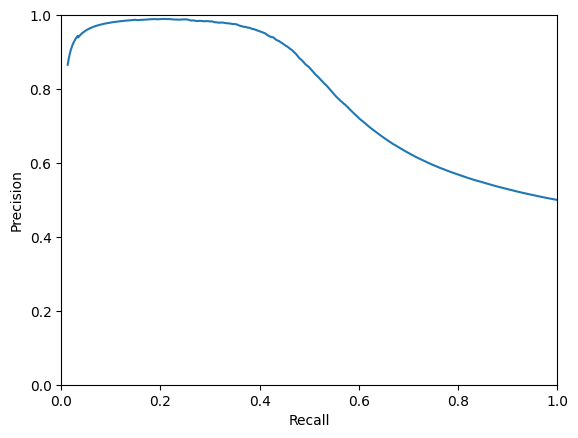

In [ ]:
fig, ax = plt.subplots()
ax.plot(recalls, precs)
ax.set_xlim(0,1.)
ax.set_ylim(0,1.)

ax.set_ylabel("Precision")
ax.set_xlabel("Recall")

plt.show()

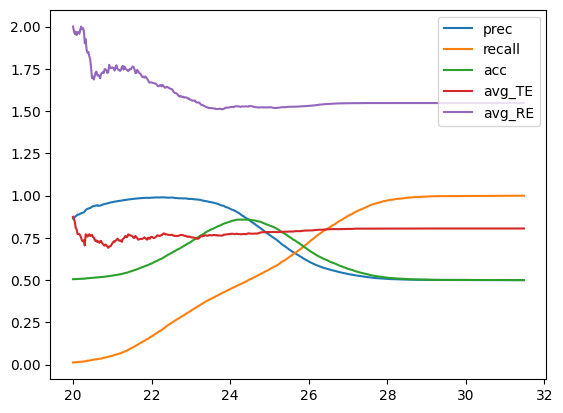

In [ ]:
plt.plot(thresholds, precs, label="prec")
plt.plot(thresholds, recalls, label="recall")
plt.plot(thresholds, accs, label="acc")
plt.plot(thresholds, avg_TEs, label="avg_TE")
plt.plot(thresholds, avg_REs, label="avg_RE")
# plt.plot(thresholds, f1s, label="f1")
plt.legend()
plt.show()

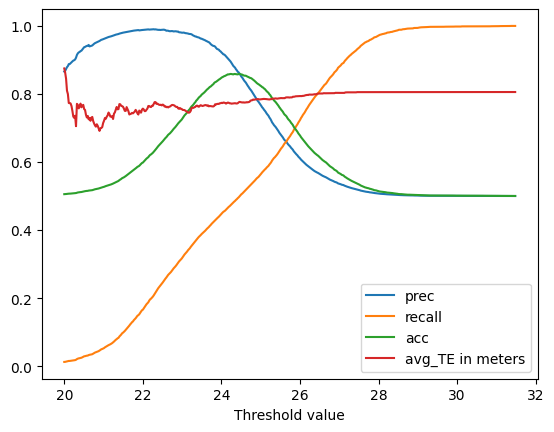

In [ ]:
plt.plot(thresholds, precs, label="prec")
plt.plot(thresholds, recalls, label="recall")
plt.plot(thresholds, accs, label="acc")
plt.plot(thresholds, avg_TEs, label="avg_TE in meters")
# plt.plot(thresholds, avg_REs, label="avg_RE")
# plt.plot(thresholds, f1s, label="f1")
plt.xlabel('Threshold value')
plt.legend()
plt.show()

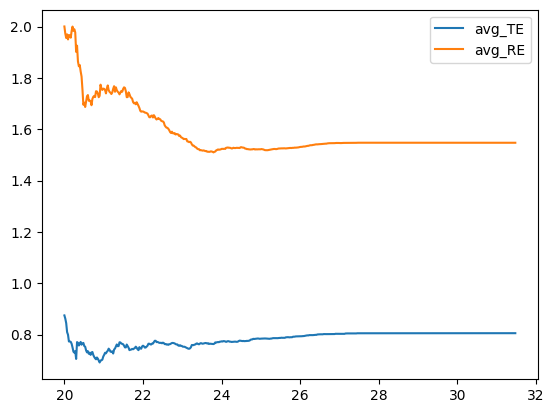

In [ ]:
# plt.plot(thresholds, precs, label="prec")
# plt.plot(thresholds, recalls, label="recall")
# plt.plot(thresholds, accs, label="acc")
plt.plot(thresholds, avg_TEs, label="avg_TE")
plt.plot(thresholds, avg_REs, label="avg_RE")
# plt.plot(thresholds, f1s, label="f1")
plt.legend()
plt.show()